# Theory of melt ponds in the Arctic sea ice

<img src="https://drive.google.com/uc?id=1T7_FTKamrhD7NW-2R5yvjw4Vd9z8ljOe" width="700"/>  
<sup>Figure 1: Melt ponds cover all floes in the Arctic summer (picture taken by Victor Lion during Polarstern cruise PS131)<sup>

## Formation process 

Melting of cryosphere compartments creates melt ponds on the ice floes. These ponds are fed on the one hand by melt water from snow on the ice, which begins to melt with the onset of increased temperatures around June each year. On the other hand, the ice on the floes counts as a source of the water, which flows to the melt ponds with a time lag. Melt ponds occur during summer months in the Arctic on almost all ice floes and can form and change in a short time interval [König & Oppelt 2020]. 

15 July 2022             |  22 July 2022 |  31 July 2022
:-------------------------:|:-------------------------:|:-------------------------:
![](https://drive.google.com/uc?id=1m4fVUF2jOjQ89nEEI5IAuERliBQdE7TK)  |  ![](https://drive.google.com/uc?id=1lMeizQMWOOFN7tZkxhQ4mRdiBE96cFo8) |  ![](https://drive.google.com/uc?id=18IYtOFA_bFEzxrySHWRE8a6AC4hsNCxq)

<sup>Table 1: Development of pond Nemo within approx. two weeks (pictures taken by Victor Lion during Polarstern cruise PS131)<sup>

##  Importance of melt ponds and their observation

The development of melt water on ice floes causes an intensification of the further melting process. This self-reinforcing process is understood as ice-albedo-feedback. The albedo (ratio between the reflected and incident solar radiation from the surface) of water surfaces is significantly lower than that of ice surfaces. Thus, if higher temperature in the Arctic lead to the formation of melt ponds on the ice floes, this leads to an increased absorption capacity of the earth's surface due to lower albedo. The increased absorption of the water in turn leads to an increase in temperature and the process is repeated and intensified [Thackeray & Hall 2019]. 

## Visual appearance of melt ponds

Melt ponds occur with extreme variability in size, depth, and color. Even within a melt pond, different water depths and mostly different color tones are present, so each pond has a distinct characteristic. Melt ponds can range in length from several to hundreds of meters and have depth ranging from several centimeters to meters. They have a wide spectrum of colors (from dark grey to light blue), and the color is not an indicator of the water depth. The color can rather be explained by the optical thickness of the underlying ice. The optical thickness depends, among other things, on whether the ice is thin or perennial, thick ice [Zege et al. 2015]. 

<img src="https://drive.google.com/uc?id=1NIId-8gIBblj2SWflQi1hnaQnDjuf93p" width="700"/>  

<sup>Figure 2: Complex visual appearance of melt ponds (picture taken by Victor Lion during Polarstern cruise PS131)<sup>

# Data and preprocessing

Training data was retrieved from a high resoulution (0.5 m) satellite classification data set during preprocessing. The data was used to train Sentinel-2 data (resolution: 10 m) originating from ESA's Copernicus programme.

<img src="https://drive.google.com/uc?id=106eJEsed83Jqtmi_mwuDg7BS8kIAHwqg" width="700"/>  

<sup>Figure 3: Reference data (left) and Sentinel-2 image (right).<sup>


In [10]:
%%capture
# install and import all libraries

import numpy as np 
import tensorflow as tf 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [11]:
# connect to google drive
!wget https://raw.githubusercontent.com/Chaosbit/opencampus_tf_melt_pond_detection/master/20200707_0perOL_v4.csv
!wget https://raw.githubusercontent.com/Chaosbit/opencampus_tf_melt_pond_detection/master/20200707_open_lead_points_v3.csv
!wget https://raw.githubusercontent.com/Chaosbit/opencampus_tf_melt_pond_detection/master/edge_pixels_20200707_more_feats_v2.csv

--2023-01-16 21:21:32--  https://github.com/Chaosbit/opencampus_tf_melt_pond_detection/blob/master/20200707_0perOL_v4.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘20200707_0perOL_v4.csv.1’

20200707_0perOL_v4.     [ <=>                ] 137.52K  --.-KB/s    in 0.07s   

2023-01-16 21:21:32 (1.80 MB/s) - ‘20200707_0perOL_v4.csv.1’ saved [140822]

--2023-01-16 21:21:32--  https://raw.githubusercontent.com/Chaosbit/opencampus_tf_melt_pond_detection/master/20200707_open_lead_points_v3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242323 (237K) [text/plain]
Saving to: ‘20200707_open_lead_po

In [12]:
# import data
data = pd.read_csv("/content/20200707_0perOL_v4.csv", on_bad_lines='skip')
open_lead = pd.read_csv(r"/content/20200707_open_lead_points_v3.csv")
edge_pixels = pd.read_csv(r"/content/edge_pixels_20200707_more_feats_v2.csv")

# show me header of data
data.head()

,<!DOCTYPE html>
0,"<html lang=""en"" data-color-mode=""auto"" data-li..."
1,<head>
2,"<meta charset=""utf-8"">"
3,"<link rel=""dns-prefetch"" href=""https://githu..."
4,"<link rel=""dns-prefetch"" href=""https://avata..."


In [9]:
print("data have " + str(len(data)) + " elements if unproccessed.")

#DEFINE SMALLEST CLASS SIZE to correctly balance
smallest_class_size = 700

# crop data (it reaches performant results)
def outlier_detection(df, col_name, balance):
    if balance:
        Q1,Q3 = np.percentile(df[col_name] , [40,60])
    else:
        Q1,Q3 = np.percentile(df[col_name] , [35,65])
    
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    
    df = df[df[col_name] > ll]
    df = df[df[col_name] < ul]
    return df
    

def transfrom_df(lower, upper, df, smallest_class_size):
    # select classes range from data frame
    df = df[df.mpf >= lower]
    df = df[df.mpf < upper]
    
    # decide which balance mode to use: Pixels with a high Melt Pond fraction are to be treated differently
    if lower >= 0.9:
        balance = False
    else:
        balance = True
    
    # perform the selection only on the spectral bands 
    df = outlier_detection(df, "b8",balance)
    df = outlier_detection(df, "b2",balance)
    df = outlier_detection(df, "b3",balance)
    df = outlier_detection(df, "b4",balance)
    
    # crop each class to the smallest pixels size

    if len(df.index) > smallest_class_size:
      df = df.sample(frac=1)
      df = df.head(smallest_class_size)

    # shuffle  
    df = df.sample(frac=1)   
    return df

# divide data sets in 10 % ranges and 
df_class_0 = transfrom_df(-0.001, 0.1, data, smallest_class_size)
df_class_1 = transfrom_df(0.1, 0.2, data, smallest_class_size)
df_class_2 = transfrom_df(0.2, 0.3, data, smallest_class_size)
df_class_3 = transfrom_df(0.3, 0.4, data, smallest_class_size)
df_class_4 = transfrom_df(0.4, 0.5, data, smallest_class_size)
df_class_5 = transfrom_df(0.5, 0.6, data, smallest_class_size)
df_class_6 = transfrom_df(0.6, 0.7, data, smallest_class_size)
df_class_7 = transfrom_df(0.7, 0.8, data, smallest_class_size)
df_class_8 = transfrom_df(0.8, 0.9, data, smallest_class_size)
df_class_9 = transfrom_df(0.9, 1.01, data, smallest_class_size)
 
############################################################################################
############################################################################################    

# concatenate dataframes for all MPF classes, and shuffle it before training
df_list = [df_class_0,df_class_1,df_class_2,df_class_3,df_class_4,
           df_class_5,df_class_6,df_class_7,df_class_8,df_class_9,open_lead,edge_pixels]


data = pd.concat(df_list, ignore_index=True) 
data = data.sample(frac=1)
      
print("data have " + str(len(data)) + " elements after preprocessing in segments.")

# check that there is no NaN value in the dataframe
columns = list(data)
for c in columns:
  data = data[data[c].notna()]


print("data have " + str(len(data)) + " elements after drop NaN")

# delete some columns which are not needed anymore
del_cols = ["brightness_vic_mean","ndbi_vic_mean", "b28_vic_mean"]
for d in del_cols:
  del data[d]

# show me header of data
data.head()

data have 1050 elements if unproccessed.


AttributeError: ignored

# Creation of a Neural Net

In [ ]:
# divide dataframe in feature and label values 
X = data.drop(['mpf'], axis = 1)
y = data['mpf']

# split data into training and test data after shuffleling (random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 20)

# scale data before training the neural network
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# print number of training and test values 
print(len(X_train), 'training samples')
print(len(X_test), 'testing samples')


print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

In [ ]:
# define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128*2, activation = 'leaky_relu'),
    tf.keras.layers.Dense(64*2, activation = 'leaky_relu'), 
    tf.keras.layers.Dense(32*2, activation = 'leaky_relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(32*2, activation = 'relu'), 
    tf.keras.layers.Dense(16*2, activation = 'relu'), 
    tf.keras.layers.Dense(1)
])

# compile model
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])

# fit model
history = model.fit(X_train, y_train, epochs = 70, validation_split = 0.1)

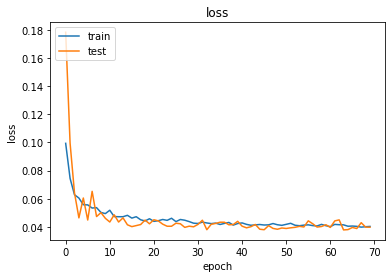

In [ ]:
# plot training and validation loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Performance evaluation

28/28 [==============================] - 0s 2ms/step


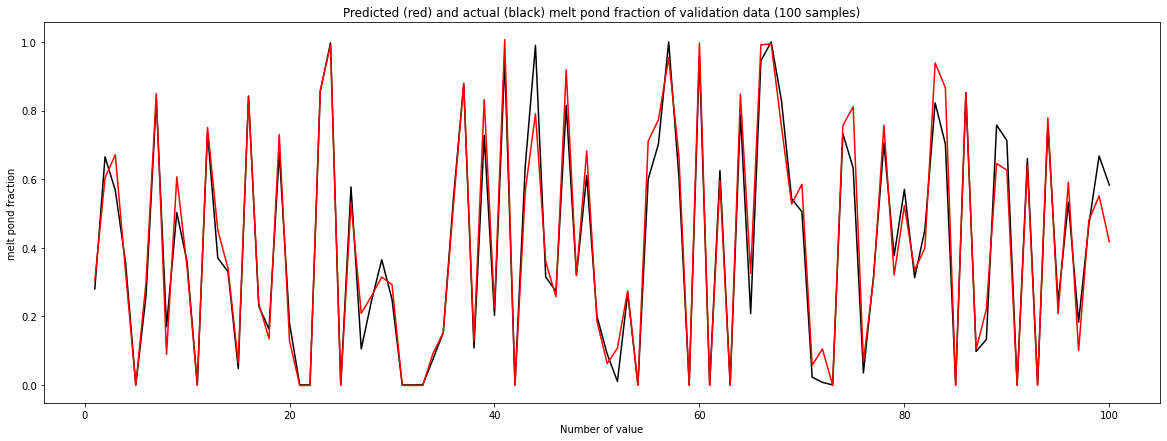

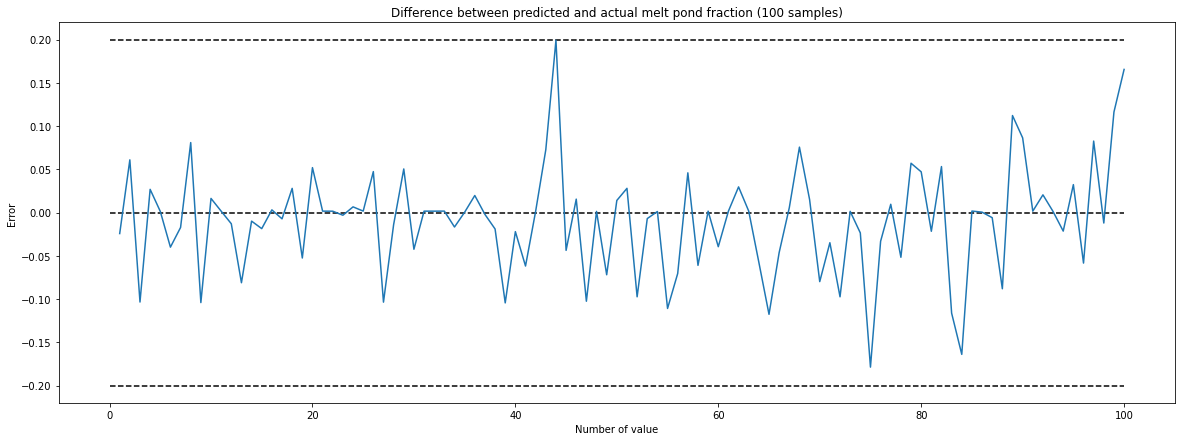

In [ ]:
# prediction of test dataset
y_pred = model.predict(X_test)

# create some plots to evaluate performance of the model

x_list = []
n = 1 
for i in range(100): 
    x_list.append(n)
    n = n + 1

df_plot = pd.DataFrame()
df_plot['y_test'] = y_test[:100]
df_plot['y_pred'] = y_pred[:100]
df_plot['x_list'] = x_list

plt.figure(figsize = (20, 7))
plt.plot(df_plot['x_list'], df_plot['y_test'], color = 'black')
plt.plot(df_plot['x_list'], df_plot['y_pred'], color = 'red')
plt.title('Predicted (red) and actual (black) melt pond fraction of validation data (100 samples)')
plt.xlabel('Number of value')
plt.ylabel('melt pond fraction')
plt.show()

plt.figure(figsize = (20, 7))
plt.plot(df_plot['x_list'], df_plot['y_test'] - df_plot['y_pred'])
plt.title('Difference between predicted and actual melt pond fraction (100 samples)')
plt.xlabel('Number of value')
plt.ylabel('Error')
plt.hlines([0.2, 0, -0.2], xmin = 0, xmax = 100, linestyles = 'dashed')
plt.show()

As a rule of thumb, the mean absolute error value should be less than 10 % of the mean of the values to be predicted.

In [ ]:
# calculate and print MAE, MSE and RMSE of model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# define variable for evaluate result
mae_predicted = metrics.mean_absolute_error(y_test, y_pred)
mean_mpf = data['mpf'].mean()

# print MAE and Mean
print('Predicted MAE: ' + str(round(mae_predicted, 3)))
print('Mean of MPF: ' + str(round(mean_mpf, 3)))

# print if the neural network is generally working fine (regarding the rule of thumb from above)
if mae_predicted < mean_mpf * 0.1:
    print('This neural network is working fine!') 
else: 
    print('This neural network is not working well!')

Mean Absolute Error: 0.03954150041805918
Mean Squared Error: 0.0029812062986509396
Root Mean Squared Error: 0.054600423978673825
Predicted MAE: 0.04
Mean of MPF: 0.403
This neural network is working fine!


# Result: Visual inspection

<img src="https://drive.google.com/uc?id=15hBz-tYOAKUBG6K8WgJw-oAfpNCYi5gG" width="700"/>  
<sup>Figure 4: Sentinel-2 image (right) and modelled melt pond fraction (left). Blue indicates MPF = 1 and white MPF = 0.<sup>


# Bibliography

<sub> König, M. & N. Oppelt (2020): A linear model to derive melt pond depth on Arctic sea ice from hyperspectral data. In: The Cryosphere 14 (8), pp. 2567-2579, URL https://doi.org/10.5194/tc-14-2567-2020. <sub>

<sub> Thackeray, C. W. & A. Hall (2019): An emergent constraint on future Arctic sea-ice albedo feedback. In: Nature Climate Change 9 (12), pp. 972-978, URL https://doi.org/10.1038/s41558-019-0619-1. <sub>

<sub> Zege, E., Malinka, A., Katsev, I., Prikhach, A., Heygster, G., Istomina, L., Birnbaum, G. & P. Schwarz (2015): Algorithm to retrieve the melt pond fraction and the spectral albedo of Arctic summer ice from satellite optical data. In: Remote Sensing of Environment 163 (1), pp. 153-164, URL https://doi.org/10.1016/j.rse.2015.03.012. <sub>